# Úkol č. 2 - předzpracování dat a binární klasifikace (do 9. listopadu 23:59)

  * V rámci tohoto úkolu se musíte vypořádat s příznaky, které jsou různých typů.
  * Před tím, než na nich postavíte predikční model, je třeba je nějakým způsobem převést do číselné reprezentace.
    
> **Úkoly jsou zadány tak, aby Vám daly prostor pro invenci. Vymyslet _jak přesně_ budete úkol řešit, je důležitou součástí zadání a originalita či nápaditost bude také hodnocena!**

## Zdroj dat

Budeme se zabývat predikcí přežití pasažérů Titaniku.
K dispozici máte trénovací data v souboru **data.csv** a data na vyhodnocení v souboru **evaluation.csv**.

#### Seznam příznaků:
* survived - zda přežil, 0 = Ne, 1 = Ano, **vysvětlovaná proměnná**, kterou chcete predikovat
* pclass - Třída lodního lístku, 1 = první, 2 = druhá, 3 = třetí
* name - jméno
* sex - pohlaví
* age - věk v letech
* sibsp	- počet sourozenců / manželů, manželek na palubě
* parch - počet rodičů / dětí na palubě
* ticket - číslo lodního lístku
* fare - cena lodního lístku
* cabin	- číslo kajuty
* embarked	- místo nalodění, C = Cherbourg, Q = Queenstown, S = Southampton
* home.dest - Bydliště/Cíl

## Pokyny k vypracování

**Základní body zadání**, za jejichž (poctivé) vypracování získáte **8 bodů**:
  * V Jupyter notebooku načtěte data ze souboru **data.csv**. Vhodným způsobem si je rozdělte na podmnožiny vhodné k trénování modelu.
  * Projděte si jednotlivé příznaky a transformujte je do vhodné podoby pro použití ve vybraném klasifikačním modelu.
  * Podle potřeby si můžete vytvářet nové příznaky (na základě existujících), například tedy můžete vytvořit příznak měřící délku jména. Některé příznaky můžete také úplně zahodit.
  * Nějakým způsobem se vypořádejte s chybějícími hodnotami.
  * Následně si vyberte vhodný klasifikační model z přednášek. Najděte vhodné hyperparametry a určete jeho přesnost (accuracy) na trénovací množině. Také určete jeho přesnost na testovací množině.
  * Načtěte vyhodnocovací data ze souboru **evaluation.csv**. Napočítejte predikce pro tyto data (vysvětlovaná proměnná v nich již není). Vytvořte **results.csv** soubor, ve kterém tyto predikce uložíte do dvou sloupců: ID, predikce přežití. Tento soubor nahrajte do repozitáře.
  * Ukázka prvních řádků souboru *results.csv*:
  
```
ID,survived
1000,0
1001,1
...
```

**Další body zadání** za případné další body  (můžete si vybrat, maximum bodů za úkol je každopádně 12 bodů):
  * (až +4 body) Aplikujte všechny klasifikační modely z přednášek a určete (na základě přesnosti na validační množině), který je nejlepší. Přesnost tohoto nejlepšího modelu odhadněte pomocí křížové validace. K predikcím na vyhodnocovacích datech využijte tento model.
  * (až +4 body) Zkuste použít nějaké (alespoň dvě) netriviální metody doplňování chybějících hodnot u věku. Zaměřte na vliv těchto metod na přesnost predikce výsledného modelu. K predikcím na vyhodnocovacích datech využijte ten přístup, který Vám vyjde jako nejlepší.

## Poznámky k odevzdání

  * Řiďte se pokyny ze stránky https://courses.fit.cvut.cz/BI-VZD/homeworks/index.html.
  * Odevzdejte nejen Jupyter Notebook, ale i _csv_ soubor s predikcemi pro vyhodnocovací data (`results.csv`).
  * Opravující Vám může umožnit úkol dodělat či opravit a získat tak další body. První verze je ale důležitá a bude-li odbytá, budete za to penalizováni**

In [1]:
import numpy as np
import pandas as pd

# Import dát

In [2]:
df = pd.read_csv('data.csv')

## Pomocné premenné

In [3]:
median_train = False
random_train = False
dtr_train = False

# Upratanie dát
Rozhodol som sa atribút **sex** zakódovať na 0/1, atribút **embarked** som sa rozhodol one-hot enkódovať, pretože som ho tam chcel nechať, no zároveň neviem určiť, čo je "lepšie", resp. nie je tam jasná spojitosť<br>
<br>
Atribúty **home.dest**, **cabin**, **ticket** a **name** som sa rozhodol vymazať, pretože neobsahovali dôležité údaje - na **home.dest** nezáleží, naloďoval sa vždy len na jednej z troch staníc (a už sa žiaľ nevylodil), **cabin** obsahuje málo dát na to, aby to bolo smerodatné a **ticket** aj v prípade, že by jeho označenie bolo špeciálne pre rôzne cenové kategórie, cenu lístka máme aj bez toho zadanú.<br>
<br>
Pri **name** som nejaký čas strávil a zamýšľal sa, či meno, resp. titul pred menom nemôže hrať rolu - u človeka so šlachtickým titulom sa predpokladá, že má viac peňazí.. avšak po zobrazení jednotlivých titulov príkazom:<br>
`df['name'].apply(lambda x: x.split(',')[1].split('.')[0].strip()).unique()`<br>
som dostal až 12 rozličných titulov a pomenovaní, ktoré som nebol schopný spojito zoradiť, pretože niektoré tituly sú anglické, niektoré sú len pomenovania osobyb (Mr./Ms.) a to zoradiť nejde - rozhodol som sa to teda tiež vyhodiť, one-hot zakódovanie výsledkom nijako nepomohlo, len to pridalo 12 nových stĺpcov a predĺžilo čas behu príkazov..

In [4]:
def clean_up_data(df):
    df['sex'] = df['sex'].astype('category').cat.codes
    df = pd.concat([df, pd.get_dummies(df['embarked'])], axis=1)
    df = df.drop(columns=['embarked', 'home.dest', 'cabin', 'ticket', 'name'])
    df = df.set_index('ID')
    df = df.fillna(-1)
    return df
df = clean_up_data(df)

# Klasifikačné modely
Pre trénovanie a testovanie som použil 4 rôzne modely klasifikácie:
 * DecisionTreeClassifier
 * RandomForestClassifier
 * AdaBoostClassifier
 * KNeighborsClassifier

In [5]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

knn = KNeighborsClassifier()
rf = RandomForestClassifier(n_estimators=100)
ada = AdaBoostClassifier()
dt = DecisionTreeClassifier()

# Doplnenie chýbajúceho veku
Po doplnení chýbajúceho veku pasažierom datasety priamo cross validujem s klasifikačnými modelmi (vypísané vyššie), nech si viem vybrať, ktorá kombinácia je najlepšia

## Doplnenie chýbajúceho veku mediánom
Prvú možnosť, ktorú som si vybral na doplnenie chýbajúcich údajov o veku pasažierov, je vyplnenie mediánom pasažierov lode (toto sme robili v 3. cvičení), nič som od toho však neočakával..

In [6]:
df_median = df.copy()
def median_age(df_median, train=None):
    global median_train
    if train:
        median = df_median.loc[df['age'] != -1]['age'].median()
        df_median['age'] = df_median['age'].apply(lambda x: median if x == -1 else x)
        median_train = median
        return df_median
    elif median_train is False:
        raise ValueError("Can't complete test dataset without train input")
    else:
        df_median['age'] = df_median['age'].apply(lambda x: median_train if x == -1 else x)
        return df_median
df_median = median_age(df_median, train=True)
df_median.tail()

,survived,pclass,sex,age,sibsp,parch,fare,C,Q,S
ID,,,,,,,,,,
995,0,3,1,27.0,0,0,7.8958,0,0,1
996,1,3,1,27.0,0,0,7.0500,0,0,1
997,0,3,0,28.0,1,1,14.4000,0,0,1
998,0,3,1,40.0,0,0,7.8958,0,0,1
999,0,3,1,27.0,0,0,7.8542,0,0,1


In [7]:
Xdata = df_median.drop(columns='survived')
ydata = df_median.survived

print('kNN accuracy:',cross_val_score(knn, Xdata, ydata, cv=10).mean())
print('Random Forest accuracy:',cross_val_score(rf, Xdata, ydata, cv=10).mean())
print('AdaBoost accuracy:',cross_val_score(ada, Xdata, ydata, cv=10).mean())
print('Decision Tree accuracy:',cross_val_score(dt, Xdata, ydata, cv=10).mean())

kNN accuracy: 0.6889999999999998
Random Forest accuracy: 0.784
AdaBoost accuracy: 0.7769999999999999
Decision Tree accuracy: 0.756


## Doplnenie chýbajúceho veku náhodnou distribúciou
Ako druhá možnosť doplnenia chýbajúceho veku mi napadlo, že pasažierom priradím náhodne vek z množiny pridelených vekov ostatných pasažierov. Ide síce čisto o náhodu, avšak doplnené údaje sa aspoň odvíjajú od reálnych dát ostatných pasažierov.

In [8]:
df_random = df.copy()
def random_age(df_random, train=None):
    global random_train
    if train:
        ages = df_random.loc[df_random['age'] != -1]['age'].to_numpy()
        df_random['age'] = df_random['age'].apply(lambda x: np.random.choice(ages, 1)[0] if x == -1 else x)
        random_train = ages
        return df_random
    elif random_train is False:
        raise ValueError("Can't complete test dataset without train input")
    else:
        df_random['age'] = df_random['age'].apply(lambda x: np.random.choice(random_train, 1)[0] if x == -1 else x)
        return df_random
df_random = random_age(df_random, train=True)
df_random.tail()

,survived,pclass,sex,age,sibsp,parch,fare,C,Q,S
ID,,,,,,,,,,
995,0,3,1,30.0,0,0,7.8958,0,0,1
996,1,3,1,25.0,0,0,7.0500,0,0,1
997,0,3,0,28.0,1,1,14.4000,0,0,1
998,0,3,1,40.0,0,0,7.8958,0,0,1
999,0,3,1,27.0,0,0,7.8542,0,0,1


In [9]:
Xdata2 = df_random.drop(columns='survived')
ydata2 = df_random.survived

print('kNN accuracy:',cross_val_score(knn, Xdata2, ydata2, cv=10).mean())
print('Random Forest accuracy:',cross_val_score(rf, Xdata2, ydata2, cv=10).mean())
print('AdaBoost accuracy:',cross_val_score(ada, Xdata2, ydata2, cv=10).mean())
print('Decision Tree accuracy:',cross_val_score(dt, Xdata2, ydata2, cv=10).mean())

kNN accuracy: 0.66
Random Forest accuracy: 0.774
AdaBoost accuracy: 0.774
Decision Tree accuracy: 0.7340000000000001


## Doplnenie chýbajúceho veku regresným stromom
Ako poslednú možnosť doplnenia chýbajúceho veku pasažierov som si vybral predikovanie veku za pomoci regresného stromu (DecisionTreeRegressor), látky preberanej na 3. cvičení. Strom sa učí na dátach, ktoré sú už známe a predikuje vek ostatným pasažierom

In [10]:
df_dtr = df.copy()
def dtr_age(df_dtr, train=None):
    global dtr_train
    if train:
        dtrXtrain = df_dtr.loc[df_dtr['age'] != -1].drop(columns=['age', 'survived'])
        dtrytrain = df_dtr.loc[df_dtr['age'] != -1]['age']

        dtrTest = df_dtr.loc[df_dtr['age'] == -1].drop(columns=['age', 'survived'])

        from sklearn.tree import DecisionTreeRegressor
        dtRegressor = DecisionTreeRegressor()
        dtRegressor.fit(dtrXtrain,dtrytrain)
        predictions = dtRegressor.predict(dtrTest)
        df_dtr.loc[df_dtr['age'] == -1]['age']
        i = 0
        for index, row in df_dtr.iterrows():
            if df_dtr.loc[index, 'age'] == -1:
                df_dtr.loc[index, 'age'] = predictions[i]
                i += 1
        dtr_train = dtRegressor
        return df_dtr
    elif dtr_train is False:
        raise ValueError("Can't complete test dataset without train input")
    else:
        dtrTest = df_dtr.loc[df_dtr['age'] == -1].drop(columns='age')
        predictions = dtr_train.predict(dtrTest)
        df_dtr.loc[df_dtr['age'] == -1]['age']
        i = 0
        for index, row in df_dtr.iterrows():
            if df_dtr.loc[index, 'age'] == -1:
                df_dtr.loc[index, 'age'] = predictions[i]
                i += 1
        return df_dtr
df_dtr = dtr_age(df_dtr, train=True)
df_dtr.tail()

,survived,pclass,sex,age,sibsp,parch,fare,C,Q,S
ID,,,,,,,,,,
995,0,3,1,27.833333,0,0,7.8958,0,0,1
996,1,3,1,28.000000,0,0,7.0500,0,0,1
997,0,3,0,28.000000,1,1,14.4000,0,0,1
998,0,3,1,40.000000,0,0,7.8958,0,0,1
999,0,3,1,27.000000,0,0,7.8542,0,0,1


In [11]:
Xdata3 = df_dtr.drop(columns='survived')
ydata3 = df_dtr.survived

print('kNN accuracy:',cross_val_score(knn, Xdata3, ydata3, cv=10).mean())
print('Random Forest accuracy:',cross_val_score(rf, Xdata3, ydata3, cv=10).mean())
print('AdaBoost accuracy:',cross_val_score(ada, Xdata3, ydata3, cv=10).mean())
print('Decision Tree accuracy:',cross_val_score(dt, Xdata3, ydata3, cv=10).mean())

kNN accuracy: 0.6759999999999999
Random Forest accuracy: 0.791
AdaBoost accuracy: 0.7770000000000001
Decision Tree accuracy: 0.76


# Ladenie hyperparametrov
Z predošlých testov mi vyšlo, že najlepšia kombinácia na validačných dátach je využitie regresného stromu na doplnenie chýbajúceho veku a použitie Random Forestu, takže som si na predikciu vybral tú.
V kóde nižšie je ladenie parametrov Random Forestu, presnejšie **n_estimators**, **criterion** a **max_features**, priebeh ladenia je zobrazený na grafe

In [12]:
from sklearn.model_selection import ParameterGrid
param_grid = {
    'n_estimators': range(10,100), 
    'criterion': ['entropy', 'gini'],
    'max_features': ['auto', 'sqrt', 'log2']
}
param_comb = ParameterGrid(param_grid)

val_acc = []
train_acc = []
for params in param_comb:
    rf = RandomForestClassifier(**params)
    rf.fit(Xdata3, ydata3)
    val_acc.append(cross_val_score(rf, Xdata3, ydata3, cv=10).mean())

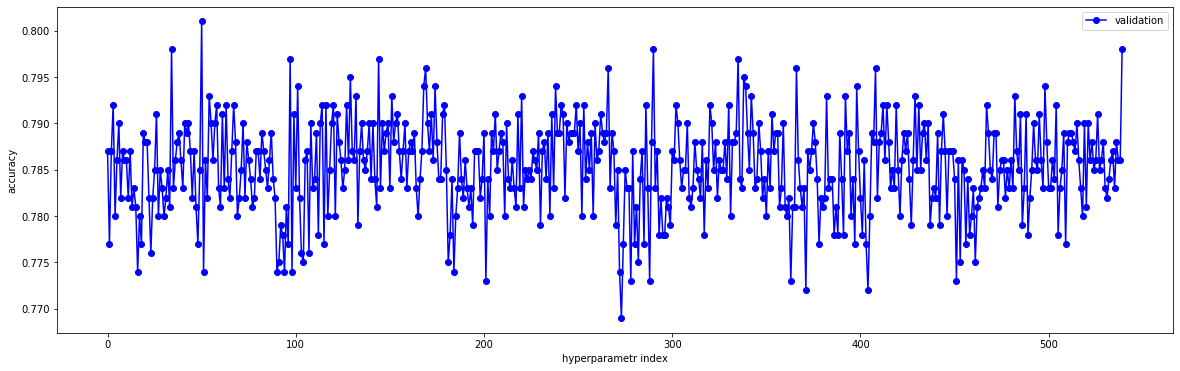

In [16]:
import matplotlib
import matplotlib.pyplot as plt
plt.figure(figsize=(20,6))
plt.plot(val_acc,'ob-')
plt.xlabel('hyperparametr index')
plt.ylabel('accuracy')
plt.legend(['validation'])

# Predikcia evaluate dát
Po vyladení hyperparametrov som si vybral najlepšie a s nimi nafitoval Random Forest.<br>
Pred konečnou predikciou som ešte upravil **evaluate.csv** dáta, aby mali rovnakú formu ako trénovacie, spustil som Random Forest a výsledné dáta zapísal do súboru **results.csv**

In [14]:
best_params = param_comb[np.argmax(val_acc)]
rfc = RandomForestClassifier(**best_params)
rfc.fit(Xdata3, ydata3)

eval_data = pd.read_csv('evaluation.csv')
eval_data = clean_up_data(eval_data)
eval_data = dtr_age(eval_data)

In [15]:
eval_predictions = rfc.predict(eval_data)

eval_results = []
for id, survived in zip(eval_data.index, eval_predictions):
    eval_results.append({'ID': id, 'Survived': survived})
pd.DataFrame(eval_results).to_csv('results.csv', index=False)